In [113]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint
%matplotlib inline 

In [95]:
def get_dataset(file_number):
    dataset_file_object = h5py.File(f"data_{file_number}.h5",'r')
    return dataset_file_object.get('x').value,dataset_file_object.get('y').value

In [101]:
def plot_dataset(X,Y):
    plt.scatter(X[:,0], X[:,1], c=Y)
    plt.xlabel('X')
    plt.ylabel('Y')

In [103]:
def get_number_of_sample(X):
    return X.shape[0]

In [112]:
def get_class_counts(Y):
    unique, counts = np.unique(Y,return_counts=True)
    return dict(zip(unique,counts))

In [114]:
def describe_dataset(X,Y):
    print(f'Number of samples in dataset are {get_number_of_sample(X)}')
    print('Classes and respective number of samples')
    pprint(get_class_counts(Y))
    plot_dataset(X,Y)

In [106]:
X,Y = get_dataset(1)

Number of samples in dataset are 100
Classes and respective number of samples
{0: 50, 1: 50}


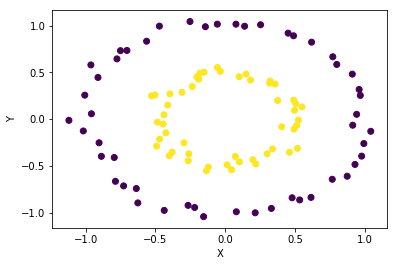

In [115]:
describe_dataset(X,Y)